# Laboratorio 3
## Universidad del Valle de Guatemala <br> Facultas de Ingeniería
#### Departamento de Ciencias de la Computación <br> Deep Learning y Sistemas Inteligentes - Sección 20

In [16]:
# Importacion de librerias
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout, LSTM
from keras.losses import Huber
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [4]:
# Leer data
data_frame = pd.read_csv('./data/monthly-sunspots.csv', usecols=[1], engine='python')
data_frame

,Sunspots
0,58.0
1,62.6
2,70.0
3,55.7
4,85.0
...,...
2815,71.8
2816,50.3
2817,55.8
2818,33.3


### Implementar 3 redes neuronales con las siguientes estructuras para resolver el problema de regresión:

In [5]:
def print_error(trainY, testY, train_predict, test_predict):        
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))    
    # Imprimir los errores de predicciones
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))    

In [6]:
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Sunspots scaled')
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')

In [7]:

# ! Documentar los resultados

### 1. Feed Forward NN (Red Simple)

In [8]:
scaler = StandardScaler()
data = scaler.fit_transform(data_frame.values)

X = np.arange(len(data)).astype(float)  # Using index as a feature
y = data.flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
def create_FFNN():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    model.summary()
    return model

In [116]:
model = create_FFNN()
# data_ffnn = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))
data_ffnn = model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=2, validation_data=(X_test, y_test))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                128       
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 193 (772.00 Byte)
Trainable params: 193 (772.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
2256/2256 - 6s - loss: 196.3330 - val_loss: 1.3695 - 6s/epoch - 3ms/step
Epoch 2/20
2256/2256 - 4s - loss: 36.3083 - val_loss: 3.0353 - 4s/epoch - 2ms/step
Epoch 3/20
2256/2256 - 5s - loss: 26.8122 - val_loss: 0.9714 - 5s/epoch - 2ms/step
Epoch 4/20
2256/2256 - 4s - loss: 52.4687 - val_loss: 10.2707 - 4s/epoch - 2ms/step
Epoch 5/20
2256/2256 - 5s - loss: 25.7378 - val_loss: 1.9777 - 5s/epoch - 2ms

In [117]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
print_error(y_train, y_test, train_predict, test_predict)

18/18 [==============================] - 0s 3ms/step
Train RMSE: 1.095 RMSE
Test RMSE: 1.071 RMSE


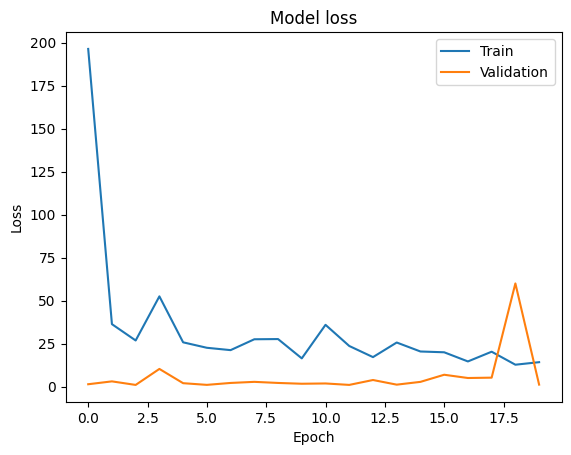

In [118]:
plt.plot(data_ffnn.history['loss'])
plt.plot(data_ffnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

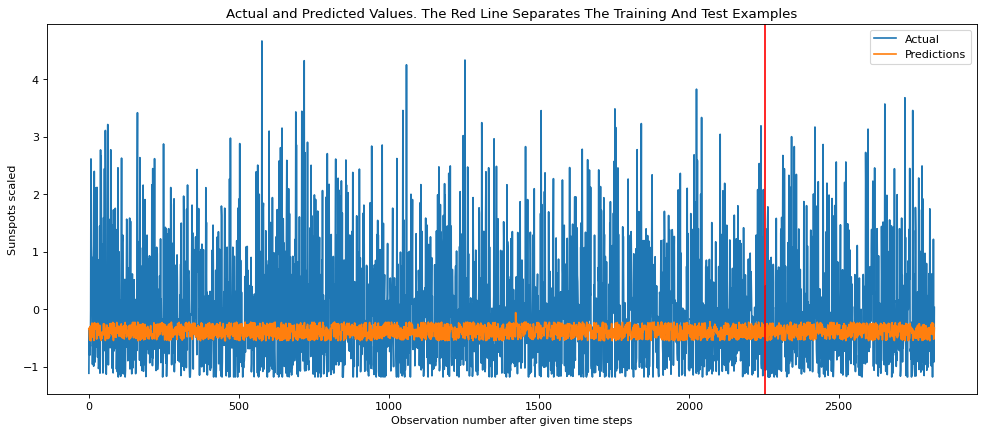

In [119]:
plot_result(y_train, y_test, train_predict, test_predict)

### 2. Recurrent Neural Network (RNN)

In [120]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(
        hidden_units
        , input_shape=input_shape
        , activation=activation[0]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [121]:
def get_train_test(df, split_percent=0.8):
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data).flatten()
    n = len(data)    
    split = int(n*split_percent)
    train_data = data[range(split)]
    test_data = data[split:]
    return train_data, test_data, data

train_data, test_data, data = get_train_test(data_frame)

In [122]:
def get_XY(dat, time_steps):    
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    Y = dat[Y_ind]    
    rows_x = len(Y) # Preparar X
    X = dat[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y
 
time_steps = 12
trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

In [123]:
model = create_RNN(
    hidden_units=3
    , dense_units=1
    , input_shape=(time_steps,1)
    , activation=['tanh', 'tanh']
)
data_rnn = model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2, validation_data=(testX, testY))

Epoch 1/20
187/187 - 2s - loss: 0.0117 - val_loss: 0.0127 - 2s/epoch - 12ms/step
Epoch 2/20
187/187 - 1s - loss: 0.0084 - val_loss: 0.0105 - 591ms/epoch - 3ms/step
Epoch 3/20
187/187 - 1s - loss: 0.0071 - val_loss: 0.0096 - 564ms/epoch - 3ms/step
Epoch 4/20
187/187 - 1s - loss: 0.0064 - val_loss: 0.0093 - 564ms/epoch - 3ms/step
Epoch 5/20
187/187 - 1s - loss: 0.0059 - val_loss: 0.0088 - 615ms/epoch - 3ms/step
Epoch 6/20
187/187 - 1s - loss: 0.0056 - val_loss: 0.0087 - 635ms/epoch - 3ms/step
Epoch 7/20
187/187 - 1s - loss: 0.0053 - val_loss: 0.0084 - 560ms/epoch - 3ms/step
Epoch 8/20
187/187 - 1s - loss: 0.0051 - val_loss: 0.0080 - 550ms/epoch - 3ms/step
Epoch 9/20
187/187 - 1s - loss: 0.0050 - val_loss: 0.0080 - 565ms/epoch - 3ms/step
Epoch 10/20
187/187 - 1s - loss: 0.0048 - val_loss: 0.0075 - 619ms/epoch - 3ms/step
Epoch 11/20
187/187 - 1s - loss: 0.0048 - val_loss: 0.0074 - 648ms/epoch - 3ms/step
Epoch 12/20
187/187 - 1s - loss: 0.0047 - val_loss: 0.0072 - 647ms/epoch - 3ms/step
Epo

In [124]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)
print_error(trainY, testY, train_predict, test_predict)

2/2 [==============================] - 0s 4ms/step
Train RMSE: 0.065 RMSE
Test RMSE: 0.081 RMSE


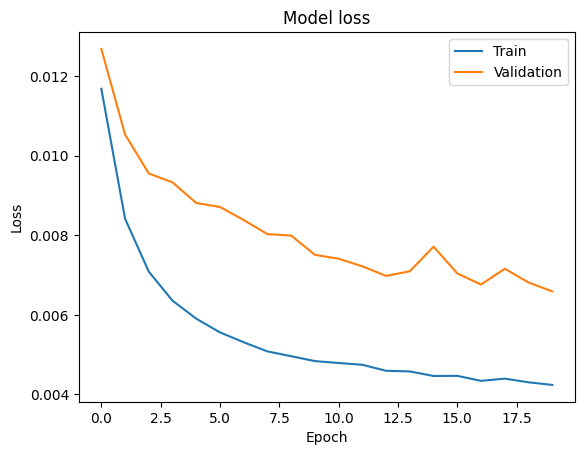

In [129]:
plt.plot(data_rnn.history['loss'])
plt.plot(data_rnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

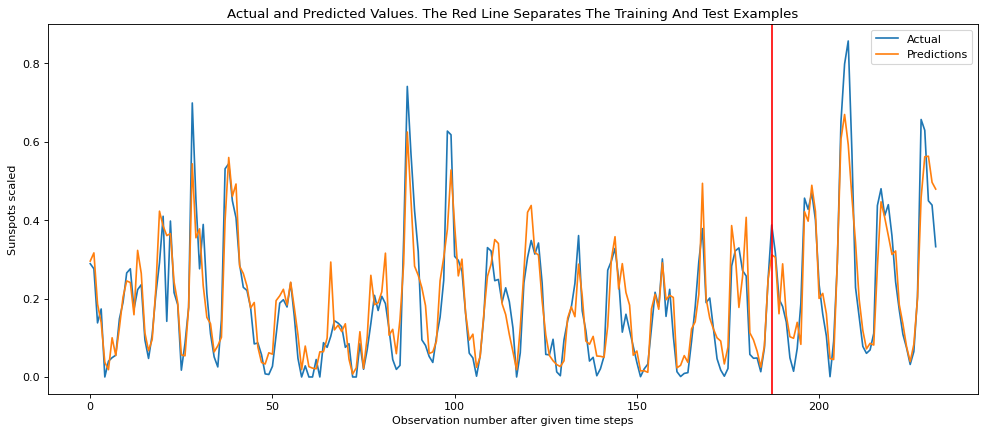

In [126]:
plot_result(trainY, testY, train_predict, test_predict)

### 3. Long Short Term Memory (LSTM)

In [134]:
data_frame.tail()

,Sunspots
2815,71.8
2816,50.3
2817,55.8
2818,33.3
2819,33.4


In [135]:
# separar en grupos
#X_train_val, X_test, y_train_val, y_test = train_test_split(
#    data_frame['Sunspots'].values,  
#    data_frame['Sunspots'].values,  
#    test_size=0.15,  
#    random_state=777  
#)
#X_train, X_validation, y_train, y_validation = train_test_split(
#    X_train_val,
#    y_train_val,
#    test_size=0.15,
#    random_state=777
#)

In [136]:
#len(data_frame), len(X_train), len(y_train), len(X_validation), len(y_validation), len(X_test), len(y_test)
#type(data_frame), type(X_train), type(y_train), type(X_validation), type(y_validation), type(X_test), type(y_test)

(2820, 2037, 2037, 360, 360, 423, 423)

In [149]:
sunspots = data_frame['Sunspots'].values.reshape(-1, 1)
scaler = MinMaxScaler()
sunspots = scaler.fit_transform(sunspots)

sequence_length = 12
sequences = []
target = []

In [150]:
for i in range(len(sunspots) - sequence_length):
    sequences.append(sunspots[i:i+sequence_length])
    target.append(sunspots[i+sequence_length])

X = np.array(sequences)
y = np.array(target)

# Split the data into training and testing sets
train_size = int(0.7 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [152]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=40, validation_split=0.2)

# Extract the loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions to the original scale
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

Epoch 1/100
40/40 [==============================] - 0s 11ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 2/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 3/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 4/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 5/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 6/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 7/100
40/40 [==============================] - 0s 7ms/step - loss: 0.0035 - val_loss: 0.0028
Epoch 8/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 9/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 10/100
40/40 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 11

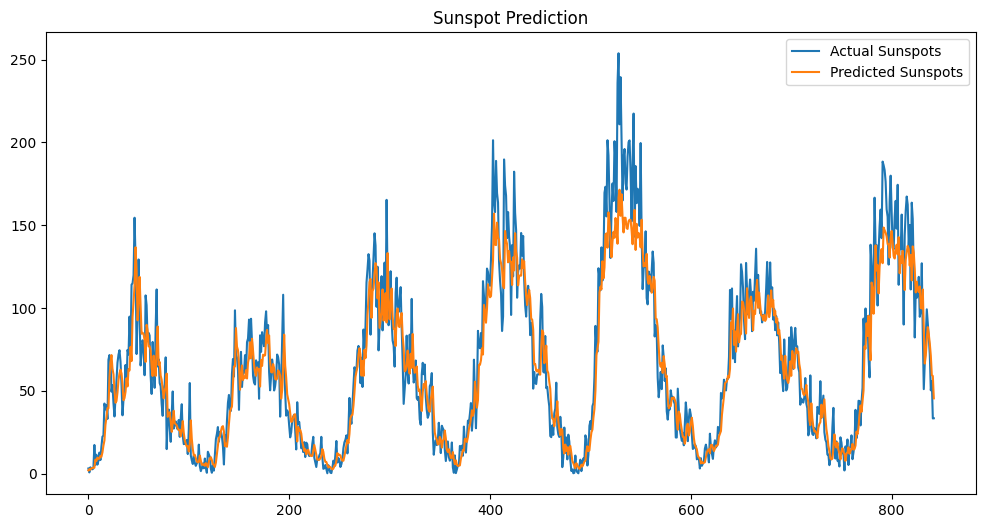

In [153]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Sunspots')
plt.plot(predictions, label='Predicted Sunspots')
plt.legend()
plt.title('Sunspot Prediction')
plt.show()

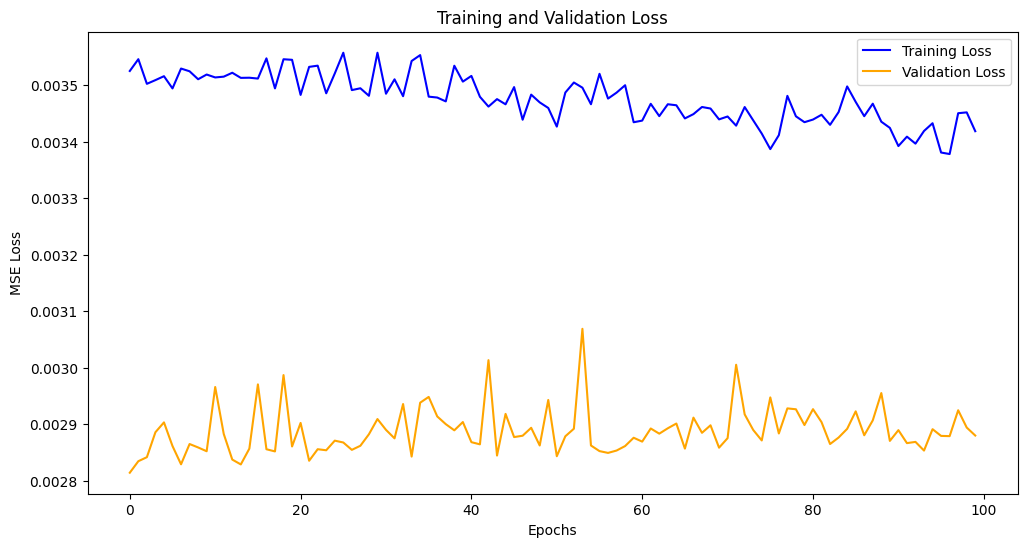

In [154]:
# Plot the MSE loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### Resultados

In [ ]:
# ! Discutir pros y contras de utilizar cada arquitectura y justificar cual sería la elección para resolver este problema 
# ! basado en los resultados obtenidos y la teoría revisada en clase.
El modelo LSTM parece ser el modelo con menor MSE lo que se traduce en que en teoría se adapta mejor a la realidad.